In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
from scipy import stats
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score
from sklearn.feature_selection import f_regression
from math import sqrt
import matplotlib.pyplot as plt 
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import env
import acquire
import features
import evaluate
import model

## Acquire and Prep
Created a function that acquired and prepped data from the Zillow Database. The minimum viable product is a model that examines the relationship between the Assessed Property Value of the desired housing units and the number of bathrooms, bedrooms, and square footage of the house. 

In [2]:
# def get_zillow_data_from_mysql():
   
#     # Use a double "%" in order to escape %'s default string formatting behavior.
#     query = '''Select props.`id` as property_id, 
#     props.`bathroomcnt` as bathroom_count,
#     props.`bedroomcnt` as bedroom_count,
#     props.`calculatedfinishedsquarefeet` as calc_finish_sq_ft,
#     props.`taxvaluedollarcnt` as assessed_property_value,
#     props.`taxamount` as tax_paid,
#     (props.`taxamount` / props.`taxvaluedollarcnt`) * 100 as tax_rate,
#     props.`fips` as county_code,
#     svi.`COUNTY` as county
#     from zillow.properties_2017 as props
#         JOIN zillow.predictions_2017 as pred
#         on zillow.props.id = zillow.pred.id
#     JOIN svi_db.`svi2016_us_county` as svi
#     on zillow.props.fips = svi_db.svi.fips
#     Where transactiondate like "2017-05%%" or transactiondate like "2017-06%%" 
#     and props.`propertylandusetypeid` not in (31, 246, 247, 248)
#     AND
#     props.`calculatedfinishedsquarefeet` IS NOT NULL
#     AND 
#     props.`bathroomcnt` != 0
#     AND
#     props.`bedroomcnt` != 0

#     '''



df = acquire.wrangle_zillow()
df

Reading data from ./zillow.csv


,property_id,bathroom_count,bedroom_count,calc_finish_sq_ft,assessed_property_value,tax_paid,tax_rate,county_code,county
0,1772,2.0,4,1604.0,498347.0,6089.82,1.222004,6037,Los Angeles
1,2028,3.0,3,2384.0,549917.0,6679.55,1.214647,6037,Los Angeles
2,3273,2.0,3,1574.0,235272.0,3876.31,1.647587,6037,Los Angeles
3,3429,2.0,2,1619.0,340000.0,4206.15,1.237103,6037,Los Angeles
4,3908,3.0,3,1936.0,418146.0,5278.74,1.262416,6037,Los Angeles
5,4505,3.0,2,2408.0,2017254.0,24353.42,1.207256,6037,Los Angeles
7,5444,3.0,6,2610.0,381514.0,5708.90,1.496380,6037,Los Angeles
8,5931,2.0,4,1721.0,629951.0,6861.51,1.089213,6037,Los Angeles
9,6926,1.0,3,1136.0,305481.0,5488.23,1.796586,6037,Los Angeles
10,7018,1.0,2,1088.0,79930.0,1498.86,1.875216,6037,Los Angeles


# Prep 

__The prep work was accomplished in the acquire.py file. Cleaning started with the SQL query. After importing to jupyter notebook, rows with nulls were excluded.__



# Data Dictionary

In [3]:
data_dict = {
    "bathroomcnt":"selected bathroomcnt because it was mandated and was the best selection ", 
    "bedroomcnt":"the bedroom count available in the database",
    "calculatedfinishedsquarefeet":"calculatedsqft had the least nulls and seemed to be the most accurate assessment of house size",
    "taxvaluedollarcnt":"this was the only assessed property tax value data",
    "taxamount":"shows how much tax was paid",
    "('taxamount` / `taxvaluedollarcnt`) * 100":"created a tax rate for each property",
    "`fips`":"provides the county code that can be merged with a join",
    "svi.`COUNTY`":"Allows the county name to be matched with the county code"
    
}

# Early visualization exploration
I wanted to see how the distribution of the independent variables looked


I wanted to get a sense of where the distributions of each variable lie to see if I could infer anything prior to running models

Also, not too proficient with data visualization, so it was good practice

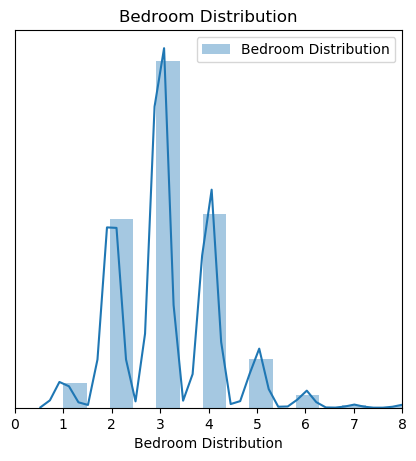

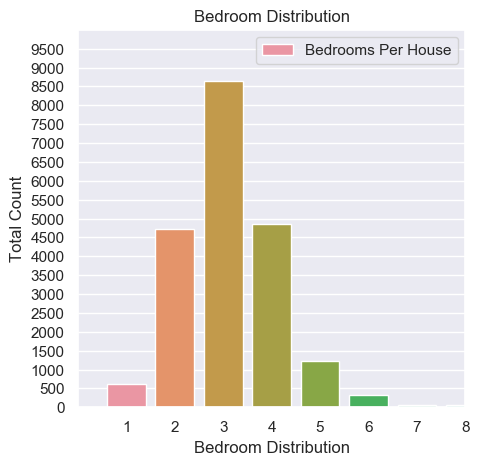

In [4]:
plt.figure(figsize = (5,5), dpi = 100, facecolor = "w")
sns.distplot(df['bedroom_count'], label = "Bedroom Distribution")
plt.xlim(0, 8)
plt.legend()
plt.yticks([])
plt.title("Bedroom Distribution")
plt.xlabel('Bedroom Distribution')
plt.show()


plt.figure(figsize = (5,5), dpi = 100, facecolor = "w")
sns.set(style="darkgrid")
ax = sns.countplot(x=df.bedroom_count, data=df, label = 'Bedrooms Per House')
plt.xlim(-1,7)
plt.ylim(0, 10000)
plt.ylabel("Total Count")
plt.legend()
plt.yticks(np.arange(0, 10000, step=500))
plt.title("Bedroom Distribution")
plt.xlabel('Bedroom Distribution')
plt.show()

# sns.catplot(x="Bedroom Number", y="Bedroom Count", data=df.sort_values('bedroom_count'))

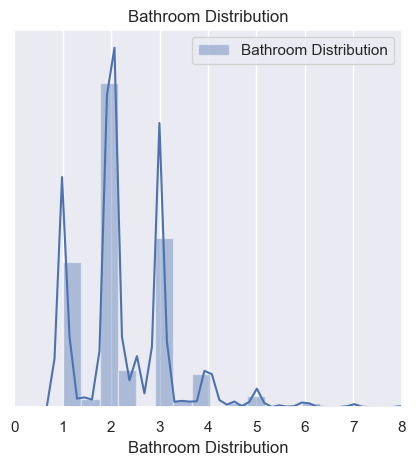

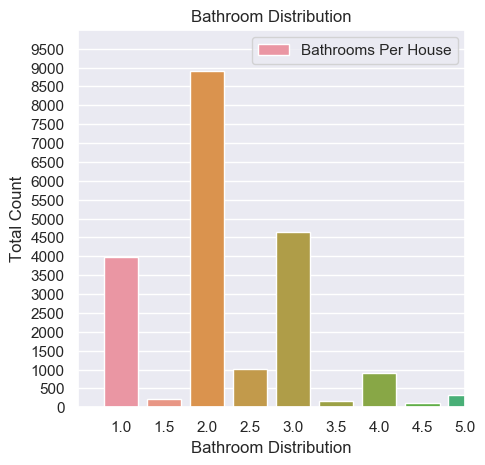

In [5]:
plt.figure(figsize = (5,5), dpi = 100, facecolor = 'w')
sns.distplot(df['bathroom_count'], label = "Bathroom Distribution")
plt.xlim(0, 8)
plt.legend()
plt.yticks([])
plt.title("Bathroom Distribution")
plt.xlabel('Bathroom Distribution')
plt.show()


plt.figure(figsize = (5,5), dpi = 100, facecolor = "w")
sns.set(style="darkgrid")
ax = sns.countplot(x=df.bathroom_count, data=df, label = 'Bathrooms Per House')
plt.xlim(-1,8)
plt.ylim(0, 10000)
plt.ylabel("Total Count")
plt.legend()
plt.yticks(np.arange(0, 10000, step=500))
plt.title("Bathroom Distribution")
plt.xlabel('Bathroom Distribution')
plt.show()

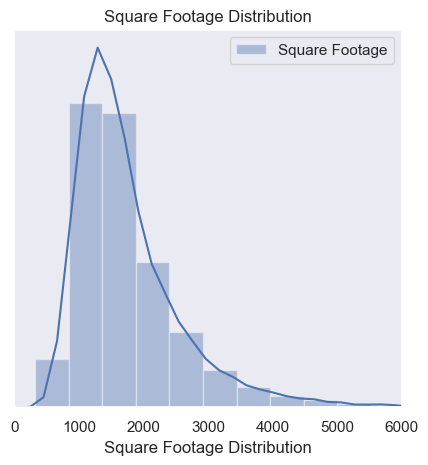

In [6]:
plt.figure(figsize = (5,5), dpi = 100)
sns.set(style="dark")
sns.distplot(df['calc_finish_sq_ft'], label = 'Square Footage')
plt.legend()
plt.yticks([])
plt.xlim(0,6000)
plt.title("Square Footage Distribution")
plt.xlabel('Square Footage Distribution')
plt.show()

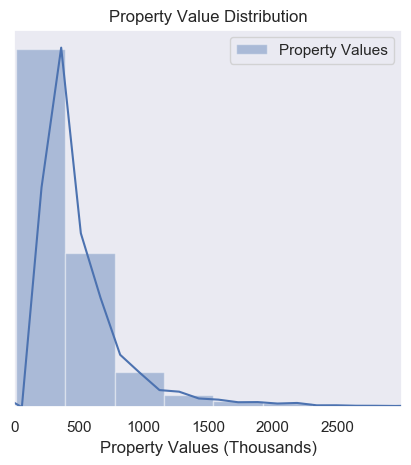

In [7]:
plt.figure(figsize = (5,5), dpi = 100)
sns.set(style="dark")
sns.distplot((df['assessed_property_value']/1000), label = "Property Values")
plt.legend()
plt.yticks([])
plt.xticks(np.arange(0, 3_000, step = 500))
plt.xlim(0, 3000)
plt.title("Property Value Distribution")
plt.xlabel('Property Values (Thousands)')
plt.show()

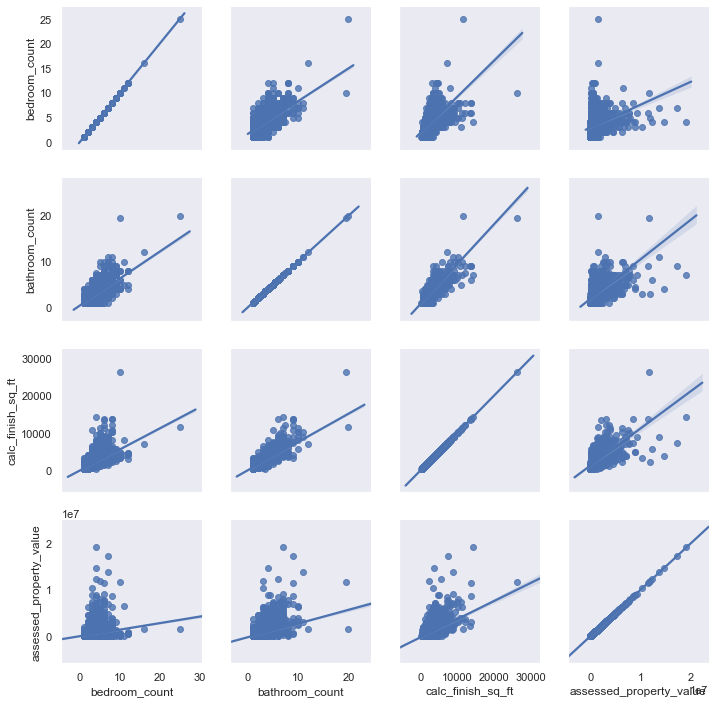

In [8]:
g=sns.PairGrid(df[['bedroom_count', 'bathroom_count', 'calc_finish_sq_ft', 'assessed_property_value']])
g.map(sns.regplot)
plt.show()

# Distribution of Tax Rates According to County
There were three counties that were identified in the query for this model: Los Angeles County, Orange County, and Ventura County.

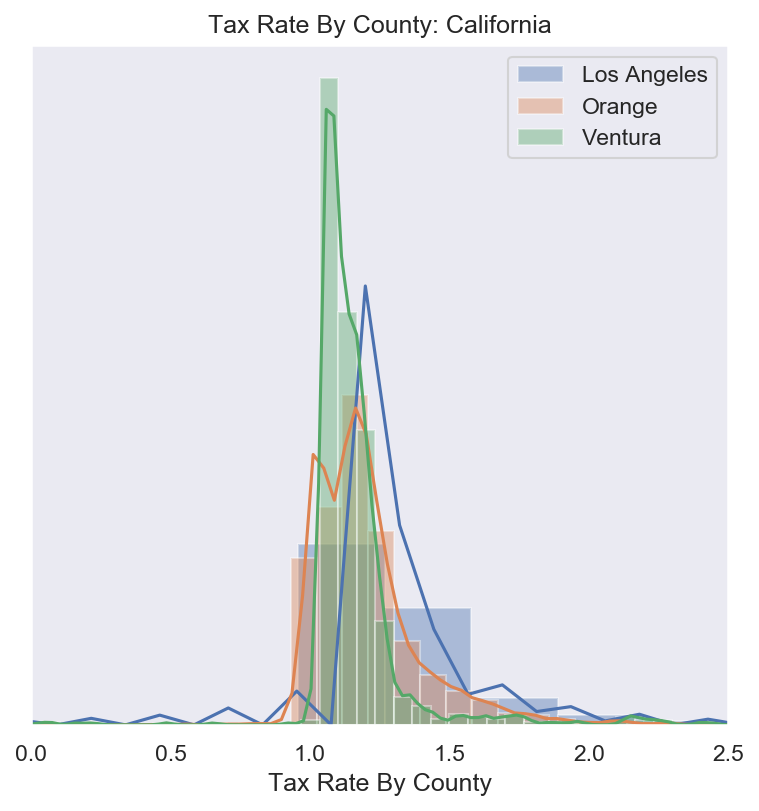

In [9]:
la_county = df.tax_rate[df.county == 'Los Angeles']
orange_county = df.tax_rate[df.county == 'Orange']
ventura_county = df.tax_rate[df.county == 'Ventura']

# len(la_county)
# len(orange_county)
# len(ventura_county)
plt.figure(figsize = (6,6), dpi = 150, facecolor = "w")
sns.distplot(la_county, label = "Los Angeles")
sns.distplot(orange_county, label = "Orange")
sns.distplot(ventura_county, label = "Ventura")
plt.xlim(0, 2.5)
plt.legend()
plt.yticks([])
plt.title("Tax Rate By County: California")
plt.xlabel('Tax Rate By County')
plt.show()

# Scaling the Data

__For data scaling, I am dropping some columns from the downloaded data set so I can create an MVP.__

__I will be creating a new dataframe so I can preserve the integrity of the original dataframe for future study__

In [10]:
# Dropping some columns for the split and scaling to create MVP, but 
# Creating a new dataframe so I can retain the other columns on reference

mvp_df = df.drop(['property_id', 'tax_paid', 'tax_rate', 'county_code', 'county'], axis = 1)
mvp_df.head()

,bathroom_count,bedroom_count,calc_finish_sq_ft,assessed_property_value
0,2.0,4,1604.0,498347.0
1,3.0,3,2384.0,549917.0
2,2.0,3,1574.0,235272.0
3,2.0,2,1619.0,340000.0
4,3.0,3,1936.0,418146.0


# SPLIT SCALE NOTES

__The Split ratio is 0.8 and the seed is 123. Using anything else will cause different results__

In [11]:
## SPLIT AND SCALE ##
## SPLIT train_ratio of 0.8 and the seed of 123##
import split_scale

train, test = split_scale.split_my_data(mvp_df, train_ratio=.8, random_seed=123)


scaler, train_scaled, test_scaled = split_scale.standard_scaler(train,test)

X = mvp_df.drop(columns='assessed_property_value')

y = mvp_df['assessed_property_value']

X_train = train.drop(columns='assessed_property_value')

y_train = train[['assessed_property_value']]

X_test = test.drop(columns='assessed_property_value')

y_test = test[['assessed_property_value']]

Xtrain_scaled = train_scaled.drop(columns='assessed_property_value')

ytrain_scaled = train_scaled[['assessed_property_value']]

Xtest_scaled = test_scaled.drop(columns='assessed_property_value')

ytest_scaled = test_scaled[['assessed_property_value']]


## DATA EXPLORATION ###

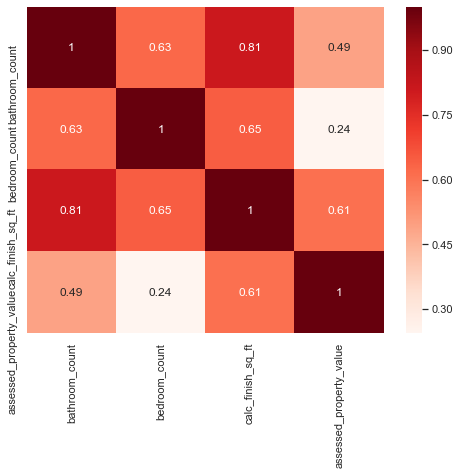

In [12]:
plt.figure(figsize=(8,6))
cor = train.corr()
sns.heatmap(cor,annot=True,cmap=plt.cm.Reds)
plt.show()

In [13]:
import statsmodels.api as sm

#OLS object to analyze features

ols_model = sm.OLS(y_train, Xtrain_scaled)
regr = sm.OLS(y, X).fit()
regr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   OLS Regression Results                                   
============================================================================================
Dep. Variable:     assessed_property_value   R-squared (uncentered):                   0.632
Model:                                 OLS   Adj. R-squared (uncentered):              0.632
Method:                      Least Squares   F-statistic:                          1.175e+04
Date:                     Sun, 20 Oct 2019   Prob (F-statistic):                        0.00
Time:                             18:17:12   Log-Likelihood:                     -2.9623e+05
No. Observations:                    20518   AIC:                                  5.925e+05
Df Residuals:                        20515   BIC:                                  5.925e+05
Df Model:                                3                                                  
Covariance Type:                 nonrobust                                                  
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
bathroom_count     4.183e+04   5309.646      7.877      0.000    3.14e+04    5.22e+04
bedroom_count     -1.476e+05   3023.278    -48.812      0.000   -1.53e+05   -1.42e+05
calc_finish_sq_ft   460.2266      5.890     78.141      0.000     448.682     471.771
==============================================================================
Omnibus:                    31016.239   Durbin-Watson:                   1.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         34079345.318
Skew:                           9.060   Prob(JB):                         0.00
Kurtosis:                     201.833   Cond. No.                     3.57e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.57e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

# Plotting Residuals

In [14]:
def plot_residuals(x, y):
    '''
    Plots the residuals of a model that uses x to predict y. Note that we don't
    need to make any predictions ourselves here, seaborn will create the model
    and predictions for us under the hood with the `residplot` function.
    '''
    return sns.residplot(x, y)

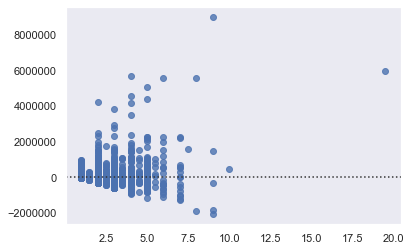

In [15]:
x = test[['bathroom_count']]
y = test[['assessed_property_value']]
plot_residuals(x,y)

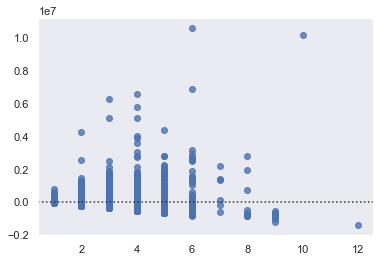

In [16]:
x = test[['bedroom_count']]
y = test[['assessed_property_value']]
plot_residuals(x,y)

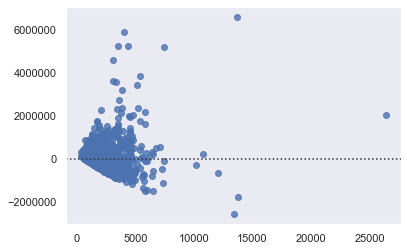

In [17]:
x = test[['calc_finish_sq_ft']]
y = test[['assessed_property_value']]
plot_residuals(x,y)

# Conclusion:

__There is room for improvement in the model__

# Fitting the model and baseline 

In [18]:
from sklearn.linear_model import LinearRegression

predictions= pd.DataFrame({'actual':y_train.assessed_property_value}).reset_index(drop=True)

#Minimal Viable Product
lm1=LinearRegression()
lm1.fit(Xtrain_scaled[['bedroom_count', 'bathroom_count', 'calc_finish_sq_ft']],y_train)
lm1_predictions=lm1.predict(Xtrain_scaled[['bedroom_count', 'bathroom_count', 'calc_finish_sq_ft']])
predictions['lm1']=lm1_predictions

lm1_y_intercept = lm1.intercept_
# print("intercept: ", lm1_y_intercept)
lm1_coefficients = lm1.coef_
# print("coefficients: ", lm1_coefficients)


#Baseline
predictions['baseline'] = y_train.mean()[0]


In [19]:
MSE_baseline = mean_squared_error(predictions.actual, predictions.baseline)
SSE_baseline = MSE_baseline*len(predictions.actual)
RMSE_baseline = sqrt(MSE_baseline)
r2_baseline = r2_score(predictions.actual, predictions.baseline)
print("MSE =",MSE_baseline, "SSE =", SSE_baseline, "RMSE =", RMSE_baseline, "R2 =", r2_baseline)

MSE = 365466657221.37354 SSE = 5998769711631625.0 RMSE = 604538.3835798795 R2 = 0.0


In [20]:
MSE_1 = mean_squared_error(predictions.actual, predictions.lm1)
SSE_1 = MSE_1*len(predictions.actual)
RMSE_1 = sqrt(MSE_1)
r2_1 = r2_score(predictions.actual, predictions.lm1)
print("MSE =", MSE_1, "SSE=", SSE_1, "RMSE=", RMSE_1, "R2=", r2_1)

# len(predictions.baseline)

MSE = 215224192988.70938 SSE= 3532689903716676.0 RMSE= 463922.6153020667 R2= 0.41109759608427976


# Analysis

__The MSE for the model returns a significantly lower result than for the baseline.__

__The r2 score is also markedly higher than the baseline r2, which reads 0.__

In [21]:
print('{} = b + m1 * {} + m2 * {} + m3 * {}'.format(y_train.columns[0], Xtrain_scaled.columns[0],Xtrain_scaled.columns[1],Xtrain_scaled.columns[2]))
print('    y-intercept  (b): %.2f' % lm1_y_intercept)
print('    coefficient (m1): %.2f' % lm1_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm1_coefficients[0][1])
print('    coefficient (m3): %.2f' % lm1_coefficients[0][2])

assessed_property_value = b + m1 * bathroom_count + m2 * bedroom_count + m3 * calc_finish_sq_ft
    y-intercept  (b): 445764.83
    coefficient (m1): -162523.96
    coefficient (m2): 43463.17
    coefficient (m3): 438046.79


In [22]:
y_pred_lm1 = lm1.predict(Xtrain_scaled)
y_pred_lm1

array([[167317.31659355],
       [255107.8466537 ],
       [484076.08828638],
       ...,
       [164025.45568957],
       [464972.9242719 ],
       [ 45981.76062471]])

# Testing Data


In [23]:
model=lm1.predict(Xtest_scaled)
model=model.ravel().reshape(4104)
y_test1=np.array(y_test).ravel().reshape(4104)
best_model=pd.DataFrame({'predictions':model,'assessed_property_value':y_test1})

best_model.head()

,predictions,assessed_property_value
0,188103.717769,280022.0
1,92236.795043,218577.0
2,396309.866338,461934.0
3,83279.460709,55353.0
4,857486.216119,1360486.0


Text(0.5, 1, 'Predicted vs Actual Tax Value')

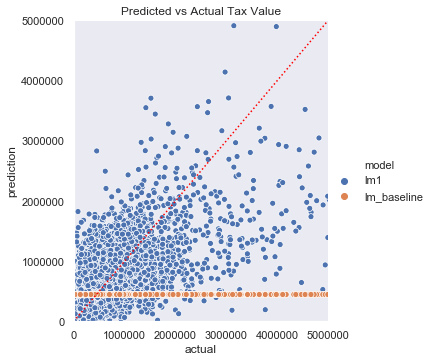

In [24]:
pd.DataFrame({'actual': predictions.actual,
              'lm1': predictions.lm1,
              'lm_baseline': predictions.baseline.ravel()})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')
min = 0
max = 5_000_000
plt.plot([min, max],[min, max], c='red', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Tax Value')

# Attempting to Improve Upon That Model With Information Already Collected

In [25]:
df = acquire.wrangle_zillow()
# df.head()

Reading data from ./zillow.csv


In [26]:
df['tax_square_ft'] = df['calc_finish_sq_ft']/df['tax_paid'] 
# df['tax_square_ft']
df

,property_id,bathroom_count,bedroom_count,calc_finish_sq_ft,assessed_property_value,tax_paid,tax_rate,county_code,county,tax_square_ft
0,1772,2.0,4,1604.0,498347.0,6089.82,1.222004,6037,Los Angeles,0.263390
1,2028,3.0,3,2384.0,549917.0,6679.55,1.214647,6037,Los Angeles,0.356910
2,3273,2.0,3,1574.0,235272.0,3876.31,1.647587,6037,Los Angeles,0.406056
3,3429,2.0,2,1619.0,340000.0,4206.15,1.237103,6037,Los Angeles,0.384913
4,3908,3.0,3,1936.0,418146.0,5278.74,1.262416,6037,Los Angeles,0.366754
5,4505,3.0,2,2408.0,2017254.0,24353.42,1.207256,6037,Los Angeles,0.098877
7,5444,3.0,6,2610.0,381514.0,5708.90,1.496380,6037,Los Angeles,0.457181
8,5931,2.0,4,1721.0,629951.0,6861.51,1.089213,6037,Los Angeles,0.250819
9,6926,1.0,3,1136.0,305481.0,5488.23,1.796586,6037,Los Angeles,0.206988
10,7018,1.0,2,1088.0,79930.0,1498.86,1.875216,6037,Los Angeles,0.725885


# Dropping columns to create a new dataframe for split/scale, etc.

In [76]:
df
model2_df = df.drop(['property_id', 'tax_paid', 'county'], axis =1)
model2_df.head()

,bathroom_count,bedroom_count,calc_finish_sq_ft,assessed_property_value,tax_rate,county_code,tax_square_ft
0,2.0,4,1604.0,498347.0,1.222004,6037,0.263390
1,3.0,3,2384.0,549917.0,1.214647,6037,0.356910
2,2.0,3,1574.0,235272.0,1.647587,6037,0.406056
3,2.0,2,1619.0,340000.0,1.237103,6037,0.384913
4,3.0,3,1936.0,418146.0,1.262416,6037,0.366754


In [77]:
train, test = split_scale.split_my_data(model2_df, train_ratio=.8, random_seed=123)

In [79]:
X_train = train.drop(columns="assessed_property_value")
X_test = test.drop(columns="assessed_property_value")
y_train = train[["assessed_property_value"]]
y_test = test[["assessed_property_value"]]

In [74]:
scaler, train_scaled, test_scaled = split_scale.standard_scaler(train,test)

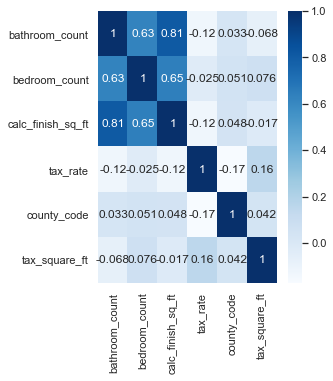

In [80]:
X_train_scaled = train_scaled.drop(columns='assessed_property_value')

y_train_scaled = train_scaled[['assessed_property_value']]

X_test_scaled = test_scaled.drop(columns='assessed_property_value')

y_test_scaled = test_scaled[['assessed_property_value']]


sns.heatmap(X_train_scaled.corr(), cmap='Blues', annot=True)
plt.show()

bathroom_count        -0.000000
bedroom_count         -0.000000
tax_rate              -0.000000
county_code           -0.000000
tax_square_ft         -0.000000
calc_finish_sq_ft    396.583654
dtype: float64

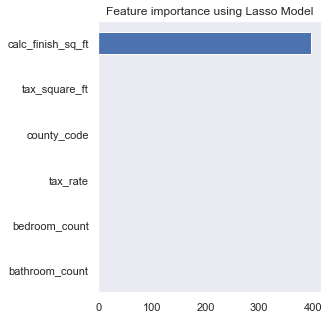

In [81]:
features.lasso_cv_coef(X_train, y_train)

In [87]:
features.num_optimal_features(X_train, y_train, X_test, y_test)

(6, 0.48815997819901497)

In [88]:
from sklearn.feature_selection import SelectKBest, f_regression, RFE
import statsmodels.api as sm
from sklearn.linear_model import LassoCV, LinearRegression

def optimal_features(X_train, X_test, y_train, number_of_features):
    '''Taking the output of optimal_number_of_features, as n, and use that value to 
    run recursive feature elimination to find the n best features'''
    cols = list(X_train.columns)
    model = LinearRegression()
    
    #Initializing RFE model
    rfe = RFE(model, number_of_features)

    #Transforming data using RFE
    train_rfe = rfe.fit_transform(X_train,y_train)
    test_rfe = rfe.transform(X_test)
    
    #Fitting the data to model
    model.fit(train_rfe, y_train)
    temp = pd.Series(rfe.support_,index = cols)
    selected_features_rfe = temp[temp==True].index
    
    X_train_rfe = pd.DataFrame(train_rfe, columns=selected_features_rfe)
    X_test_rfe = pd.DataFrame(test_rfe, columns=selected_features_rfe)
    
    return selected_features_rfe, X_train_rfe, X_test_rfe

In [90]:
optimal_features(X_train, X_test, y_train, 6)
X_train_rfe = optimal_features(X_train, X_test, y_train, 6)[1]
X_test_rfe = optimal_features(X_train, X_test, y_train, 6)[2]
X_train_rfe
# X

,bathroom_count,bedroom_count,calc_finish_sq_ft,tax_rate,county_code,tax_square_ft
0,2.0,2.0,1192.0,1.231905,6037.0,0.233020
1,2.5,3.0,1463.0,1.015134,6059.0,0.246961
2,2.0,4.0,1694.0,1.736701,6037.0,0.982388
3,2.0,3.0,1103.0,1.367795,6059.0,0.526256
4,3.0,4.0,2380.0,1.555907,6037.0,1.108173
5,2.0,5.0,1716.0,1.526779,6037.0,0.491589
6,1.0,2.0,741.0,2.482848,6037.0,0.561287
7,2.0,3.0,1803.0,1.707196,6037.0,0.261483
8,2.0,3.0,1422.0,1.243410,6037.0,0.282630
9,2.0,3.0,1064.0,1.383199,6037.0,0.363056


In [91]:
from sklearn.linear_model import LinearRegression

predictions= pd.DataFrame({'actual':y_train.assessed_property_value}).reset_index(drop=True)

#Minimal Viable Product
lm1=LinearRegression()
lm1.fit(Xtrain_scaled[['bedroom_count', 'bathroom_count', 'calc_finish_sq_ft']],y_train)
lm1_predictions=lm1.predict(Xtrain_scaled[['bedroom_count', 'bathroom_count', 'calc_finish_sq_ft']])
predictions['lm1']=lm1_predictions

lm1_y_intercept = lm1.intercept_
# print("intercept: ", lm1_y_intercept)
lm1_coefficients = lm1.coef_
# print("coefficients: ", lm1_coefficients)

#Second Model
lm2 =LinearRegression()
lm2.fit(X_train_rfe,y_train)
lm2_predictions=lm2.predict(X_train_rfe)
predictions['lm2']=lm2_predictions

lm2_y_intercept = lm2.intercept_
# print("intercept: ", lm1_y_intercept)
lm2_coefficients = lm2.coef_
# print("coefficients: ", lm1_coefficients)


#Baseline
predictions['baseline'] = y_train.mean()[0]


In [92]:
MSE_1 = mean_squared_error(predictions.actual, predictions.lm1)
SSE_1 = MSE_1*len(predictions.actual)
RMSE_1 = sqrt(MSE_1)
r2_1 = r2_score(predictions.actual, predictions.lm1)
print("MSE =", MSE_1, "SSE=", SSE_1, "RMSE=", RMSE_1, "R2=", r2_1)

MSE = 215224192988.70938 SSE= 3532689903716676.0 RMSE= 463922.6153020667 R2= 0.41109759608427976


In [93]:
MSE_2 = mean_squared_error(predictions.actual, predictions.lm2)
SSE_2 = MSE_2*len(predictions.actual)
RMSE_2 = sqrt(MSE_2)
r2_2 = r2_score(predictions.actual, predictions.lm2)
print("MSE =", MSE_2, "SSE=", SSE_2, "RMSE=", RMSE_2, "R2=", r2_2)

MSE = 187060461799.72095 SSE= 3070410419980619.5 RMSE= 432504.86910521705 R2= 0.488159978199015


In [94]:
print('{} = b + m1 * {} + m2 * {} + m3 * {}+ m4 * {} + m5 * {} + m6 * {}'.format(y_train.columns[0], X_train_rfe.columns[0],X_train_rfe.columns[1],X_train_rfe.columns[2],X_train_rfe.columns[3],X_train_rfe.columns[4],X_train_rfe.columns[5]))
print('    y-intercept  (b): %.2f' % lm2_y_intercept)
print('    coefficient (m1): %.2f' % lm2_coefficients[0][0])
print('    coefficient (m2): %.2f' % lm2_coefficients[0][1])
print('    coefficient (m3): %.2f' % lm2_coefficients[0][2])
print('    coefficient (m4): %.2f' % lm2_coefficients[0][3])
print('    coefficient (m5): %.2f' % lm2_coefficients[0][4])
print('    coefficient (m6): %.2f' % lm2_coefficients[0][5])

assessed_property_value = b + m1 * bathroom_count + m2 * bedroom_count + m3 * calc_finish_sq_ft+ m4 * tax_rate + m5 * county_code + m6 * tax_square_ft
    y-intercept  (b): 4217591.62
    coefficient (m1): 4597.97
    coefficient (m2): -116979.29
    coefficient (m3): 473.41
    coefficient (m4): -124599.05
    coefficient (m5): -648.26
    coefficient (m6): -331020.03


In [95]:
model2=lm2.predict(X_test_rfe)
model2=model2.ravel().reshape(4104)
y_test2=np.array(y_test).ravel().reshape(4104)
best_model=pd.DataFrame({'predictions':model2,'assessed_property_value':y_test2})

best_model.head()

,predictions,assessed_property_value
0,2.617714e+05,280022.0
1,3.976646e+05,218577.0
2,4.769700e+05,461934.0
3,-4.096093e+04,55353.0
4,1.299233e+06,1360486.0


Text(0.5, 1, 'Predicted vs Actual Tax Value')

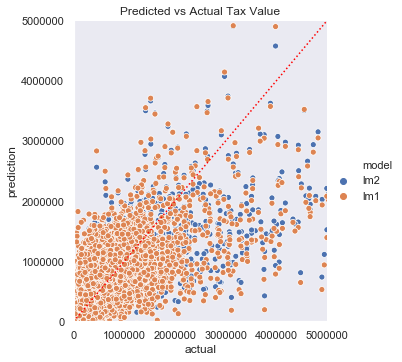

In [96]:
pd.DataFrame({'actual': predictions.actual,
              'lm2': predictions.lm2,
              'lm1': predictions.lm1.ravel()})\
.melt(id_vars=['actual'], var_name='model', value_name='prediction')\
.pipe((sns.relplot, 'data'), x='actual', y='prediction', hue='model')
min = 0
max = 5_000_000
plt.plot([min, max],[min, max], c='red', ls=':')
plt.ylim(min, max)
plt.xlim(min, max)
plt.title('Predicted vs Actual Tax Value')

In [58]:
def plot_residuals(x, y):
    '''
    Plots the residuals of a model that uses x to predict y. Note that we don't
    need to make any predictions ourselves here, seaborn will create the model
    and predictions for us under the hood with the `residplot` function.
    '''
    return sns.residplot(x, y)

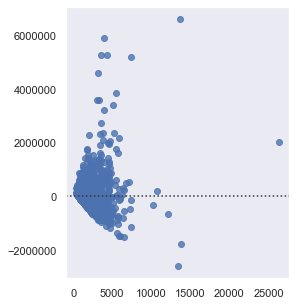

In [62]:
x = X_test_rfe[['calc_finish_sq_ft']]
y = test[['assessed_property_value']]
plot_residuals(x,y)

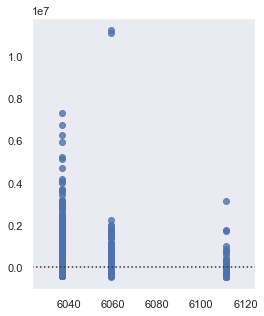

In [63]:
x = X_test_rfe[['county_code']]
y = test[['assessed_property_value']]
plot_residuals(x,y)

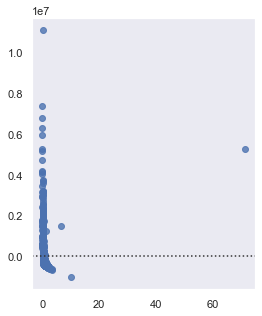

In [99]:
x = X_test_rfe[['tax_square_ft']]
y = test[['assessed_property_value']]
plot_residuals(x,y)

# Conclusion:

__The new model appears to perform slightly better than the MVP through the incorporation of a tax rate per finished square foot__


___Just realized the the tax_rate was calculated using a derivative of future data....disregard this new model___

__The next step would be to generate different data from a new query. I suspect that being more specific with the search criteria will lead to better models(i.e. limiting the search to specific building types and in specific areas).__